#BDDA Project 1
<BR>Problem 1: Text Classification

Made By: Aman Manocha
<BR>Roll No.: 015001

In [ ]:
# Libraries imported
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import length
import pyspark.ml.feature
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer,VectorAssembler

In [ ]:
spark = SparkSession.builder.appName('Question1').getOrCreate()

In [ ]:
df = spark.read.csv('Corona_NLP_train.csv', header=True, inferSchema=True, multiLine=True, sep=',')

## Exploratory Data Analysis

In [ ]:
df.show()

+--------------------+----------+--------------------+----------+--------------------+------------------+
|            UserName|ScreenName|            Location|   TweetAt|       OriginalTweet|         Sentiment|
+--------------------+----------+--------------------+----------+--------------------+------------------+
|                3799|     48751|              London|16-03-2020|@MeNyrbie @Phil_G...|           Neutral|
|                3800|     48752|                  UK|16-03-2020|advice Talk to yo...|          Positive|
|                3801|     48753|           Vagabonds|16-03-2020|Coronavirus Austr...|          Positive|
|                3802|     48754|                null|16-03-2020|My food stock is ...|          Positive|
|                3803|     48755|                null|16-03-2020|Me, ready to go a...|Extremely Negative|
|                3804|     48756|ÜT: 36.319708,-82...|16-03-2020|As news of the re...|          Positive|
|                3805|     48757|35.926541,-78

In [ ]:
# Filtering sentiments out of data
sentiments = ['Extremely Positive','Positive','Neutral','Negative','Extremely Negative']
df = df.filter(df.Sentiment.isin(sentiments))

In [ ]:
df.show()

+--------+----------+--------------------+----------+--------------------+------------------+
|UserName|ScreenName|            Location|   TweetAt|       OriginalTweet|         Sentiment|
+--------+----------+--------------------+----------+--------------------+------------------+
|    3799|     48751|              London|16-03-2020|@MeNyrbie @Phil_G...|           Neutral|
|    3800|     48752|                  UK|16-03-2020|advice Talk to yo...|          Positive|
|    3801|     48753|           Vagabonds|16-03-2020|Coronavirus Austr...|          Positive|
|    3802|     48754|                null|16-03-2020|My food stock is ...|          Positive|
|    3803|     48755|                null|16-03-2020|Me, ready to go a...|Extremely Negative|
|    3804|     48756|ÜT: 36.319708,-82...|16-03-2020|As news of the re...|          Positive|
|    3805|     48757|35.926541,-78.753267|16-03-2020|"Cashier at groce...|          Positive|
|    3806|     48758|             Austria|16-03-2020|Was at 

In [ ]:
# Schema of all columns 
df.printSchema()

root
 |-- UserName: string (nullable = true)
 |-- ScreenName: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- TweetAt: string (nullable = true)
 |-- OriginalTweet: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [ ]:
# Count of columns
len(df.columns)

6

In [ ]:
# Count of rows 
df.count()

40026

In [ ]:
# Null values
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+----------+--------+-------+-------------+---------+
|UserName|ScreenName|Location|TweetAt|OriginalTweet|Sentiment|
+--------+----------+--------+-------+-------------+---------+
|       0|         0|    8387|      0|            0|        0|
+--------+----------+--------+-------+-------------+---------+



+------------------+
|         Sentiment|
+------------------+
|Extremely Negative|
|           Neutral|
|          Positive|
|          Negative|
|Extremely Positive|
+------------------+

+------------------+-----+
|         Sentiment|count|
+------------------+-----+
|Extremely Negative| 5311|
|           Neutral| 7557|
|          Positive|11129|
|          Negative| 9602|
|Extremely Positive| 6427|
+------------------+-----+



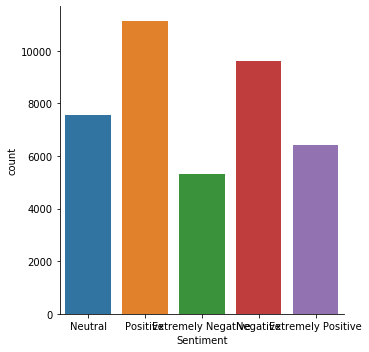

In [ ]:
# Grouping by 'Sentiment' 
df.select('Sentiment').distinct().show()
df.groupby('Sentiment').count().show()
dx = df.toPandas()
sns.catplot(x='Sentiment', kind='count', data=dx)

## Data Preprocessing 

In [ ]:
# Selecting Original Tweet and Sentiment
df = df.select('OriginalTweet','Sentiment')

In [ ]:
df = df.withColumn('Length',length(df['OriginalTweet']))

In [ ]:
df.show(5)

+--------------------+------------------+------+
|       OriginalTweet|         Sentiment|Length|
+--------------------+------------------+------+
|@MeNyrbie @Phil_G...|           Neutral|   111|
|advice Talk to yo...|          Positive|   237|
|Coronavirus Austr...|          Positive|   131|
|My food stock is ...|          Positive|   301|
|Me, ready to go a...|Extremely Negative|   306|
+--------------------+------------------+------+
only showing top 5 rows



In [ ]:
# Mean of the length grouped by sentiments
df.groupby('Sentiment').mean().show()

+------------------+------------------+
|         Sentiment|       avg(Length)|
+------------------+------------------+
|Extremely Negative|219.29128224439842|
|           Neutral|165.81328569538178|
|          Positive| 204.8383502560877|
|          Negative| 200.7849406373672|
|Extremely Positive| 226.0751517037498|
+------------------+------------------+



##Feature Engineering

In [ ]:
labelEncoder = StringIndexer(inputCol='Sentiment', outputCol='label')
tokenizer = Tokenizer(inputCol='OriginalTweet' , outputCol = 'token_text')
stopwords_remover = StopWordsRemover(inputCol='token_text' , outputCol='stop_tokens')
vectorizer = CountVectorizer(inputCol='stop_tokens' , outputCol='c_vec')
idf = IDF(inputCol='c_vec' , outputCol='tf_idf')
vas_features = VectorAssembler(inputCols=['tf_idf','Length'] , outputCol='features')

In [ ]:
# Sentiments as labels
df1 = df
labelEncoder = StringIndexer(inputCol='Sentiment', outputCol='label').fit(df1)
labelEncoder.transform(df1).show(5)

+--------------------+------------------+------+-----+
|       OriginalTweet|         Sentiment|Length|label|
+--------------------+------------------+------+-----+
|@MeNyrbie @Phil_G...|           Neutral|   111|  2.0|
|advice Talk to yo...|          Positive|   237|  0.0|
|Coronavirus Austr...|          Positive|   131|  0.0|
|My food stock is ...|          Positive|   301|  0.0|
|Me, ready to go a...|Extremely Negative|   306|  4.0|
+--------------------+------------------+------+-----+
only showing top 5 rows



##Modelling

In [ ]:
lr = LogisticRegression(featuresCol='features',labelCol='label')
nb = NaiveBayes(smoothing=1.0 , modelType='multinomial')
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label')
rf = RandomForestClassifier(featuresCol='features',labelCol='label')

In [ ]:
# Data Pipelining
pipeline = Pipeline(stages=[labelEncoder,tokenizer,stopwords_remover,vectorizer,idf,vas_features])

In [ ]:
pipe = pipeline.fit(df)

In [ ]:
pipe = pipe.transform(df)

In [ ]:
p_model = pipe.select(['label','features'])

In [ ]:
p_model.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  2.0|(116272,[19514,47...|
|  0.0|(116272,[13,16,13...|
|  0.0|(116272,[7,16,35,...|
|  0.0|(116272,[0,1,4,9,...|
|  4.0|(116272,[0,1,4,5,...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
#Splitting of the data 
train_data,test_data = p_model.randomSplit((0.7,0.3), seed=1234)
train_data.show(5)
test_data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(116272,[0,1,2,4,...|
|  0.0|(116272,[0,1,2,4,...|
|  0.0|(116272,[0,1,2,4,...|
|  0.0|(116272,[0,1,2,4,...|
|  0.0|(116272,[0,1,2,4,...|
+-----+--------------------+
only showing top 5 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(116272,[0,1,2,3,...|
|  0.0|(116272,[0,1,2,3,...|
|  0.0|(116272,[0,1,2,4,...|
|  0.0|(116272,[0,1,2,8,...|
|  0.0|(116272,[0,1,2,8,...|
+-----+--------------------+
only showing top 5 rows



## Naive Bayes Classifier Model

In [ ]:
prediction_nb = nb.fit(train_data)

In [ ]:
prediction_nbt = prediction_nb.transform(test_data)
prediction_nb_df = prediction_nbt.select('features','label','prediction')
prediction_nb_df.show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(116272,[0,1,2,3,...|  0.0|       1.0|
|(116272,[0,1,2,3,...|  0.0|       2.0|
|(116272,[0,1,2,4,...|  0.0|       0.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,8,...|  0.0|       0.0|
|(116272,[0,1,2,8,...|  0.0|       3.0|
|(116272,[0,1,2,8,...|  0.0|       1.0|
|(116272,[0,1,2,9,...|  0.0|       3.0|
|(116272,[0,1,2,9,...|  0.0|       1.0|
|(116272,[0,1,2,9,...|  0.0|       0.0|
|(116272,[0,1,2,9,...|  0.0|       2.0|
|(116272,[0,1,2,9,...|  0.0|       1.0|
|(116272,[0,1,2,9,...|  0.0|       2.0|
|(116272,[0,1,2,9,...|  0.0|       4.0|
|(116272,[0,1,2,9,...|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
acc_eval = MulticlassClassificationEvaluator()
acc_nb = acc_eval.evaluate(prediction_nb_df)
print("Accuracy of the model: ", acc_nb)

Accuracy of the model:  0.40796539150719197


## Decision Tree Classifier Model

In [ ]:
prediction_dt = dt.fit(train_data.sample(0.1))

In [ ]:
prediction_dtt = prediction_dt.transform(test_data.sample(0.1))
prediction_dt_df = prediction_dtt.select('features','label','prediction')
prediction_dt_df.show()

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(116272,[0,1,2,4,...|  0.0|       0.0|
|(116272,[0,1,2,9,...|  0.0|       0.0|
|(116272,[0,1,2,11...|  0.0|       2.0|
|(116272,[0,1,2,20...|  0.0|       0.0|
|(116272,[0,1,2,27...|  0.0|       0.0|
|(116272,[0,1,2,91...|  0.0|       0.0|
|(116272,[0,1,3,6,...|  0.0|       0.0|
|(116272,[0,1,3,6,...|  0.0|       2.0|
|(116272,[0,1,3,6,...|  0.0|       0.0|
|(116272,[0,1,3,6,...|  0.0|       0.0|
|(116272,[0,1,3,6,...|  0.0|       2.0|
|(116272,[0,1,3,9,...|  0.0|       0.0|
|(116272,[0,1,3,25...|  0.0|       0.0|
|(116272,[0,1,3,40...|  0.0|       0.0|
|(116272,[0,1,4,49...|  0.0|       0.0|
|(116272,[0,1,5,7,...|  0.0|       0.0|
|(116272,[0,1,5,9,...|  0.0|       0.0|
|(116272,[0,1,5,14...|  0.0|       0.0|
|(116272,[0,1,5,33...|  0.0|       2.0|
|(116272,[0,1,6,7,...|  0.0|       2.0|
+--------------------+-----+----------+
only showing top 20 rows



In [ ]:
acc_eval = MulticlassClassificationEvaluator()
acc_dt = acc_eval.evaluate(prediction_dt_df)
print("Accuracy of the model: ", acc_dt)

Accuracy of the model:  0.2777341902940897


Naive Bayes Classifier Model has higher accuracy than decision tree